In [1]:
%matplotlib inline

In [2]:
import sys
sys.path.append("../../")

In [3]:
import eventx
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import seaborn as sns
import io

from itertools import chain, accumulate

from eventx.predictors.predictor_utils import load_predictor
from eventx.models.model_utils import batched_predict_json
from eventx.predictors import snorkel_predictor, smartdata_predictor
from eventx.util import scorer
from eventx.util import utils
from eventx.util import evaluate
from eventx import SD4M_RELATION_TYPES, ROLE_LABELS

from allennlp.predictors import Predictor

In [4]:
from typing import List

In [5]:
CUDA_DEVICE = -1  # or -1 if no GPU is available

In [6]:
# Change paths
DATASET_PATH = "../../data/daystream_corpus/test/test_sd4m_with_events.jsonl"
MODEL_DIR = "../../data/runs/snorkel_bert_daystream"

PREDICTOR_NAME = "snorkel-eventx-predictor"
# PREDICTOR_NAME = "smartdata-eventx-predictor"

In [7]:
predictor = load_predictor(MODEL_DIR, PREDICTOR_NAME, CUDA_DEVICE)

In [8]:
def plot_confusion_matrix(y_true, y_pred, labels, title='Normalized Confusion Matrix', normalize=True):
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, labels=labels)
    if normalize:
        # Normalizes confusion matrix over the true (rows)
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm, index = labels, columns = labels)
    plt.figure(figsize = (10,7))
    ax = plt.axes()
    sns.heatmap(df_cm, ax=ax, annot=True)
    ax.set_title(title)
    plt.show()

## Load the test data and do predictions

Filter documents that do not contain any entity of type trigger as they are not relevant for the event extraction task.

In [9]:
test_docs = evaluate.load_test_data(DATASET_PATH)

In [10]:
predicted_docs = batched_predict_json(predictor=predictor, examples=test_docs)

## Conventional evaluation using sklearn toolkit
We simply consider the trigger & role label sequences disregarding the correctness of the corresponding trigger label when evaluating the argument roles to use the sklearn toolkit.

In [11]:
label_arrays = evaluate.get_label_arrays(test_docs, predicted_docs)
trigger_y_true, trigger_y_pred = label_arrays["trigger_y_true"], label_arrays["trigger_y_pred"]
arg_y_true, arg_y_pred = label_arrays["arg_y_true"], label_arrays["arg_y_pred"]

### Trigger classification

In [12]:
print(sklearn.metrics.classification_report(trigger_y_true, trigger_y_pred, SD4M_RELATION_TYPES[:-1]))

                        precision    recall  f1-score   support

              Accident       0.89      0.89      0.89         9
         CanceledRoute       1.00      0.70      0.82        10
          CanceledStop       1.00      1.00      1.00         3
                 Delay       1.00      1.00      1.00         2
           Obstruction       0.85      0.92      0.88        12
RailReplacementService       1.00      0.60      0.75         5
            TrafficJam       0.87      0.81      0.84        16

             micro avg       0.90      0.82      0.86        57
             macro avg       0.94      0.85      0.88        57
          weighted avg       0.91      0.82      0.86        57



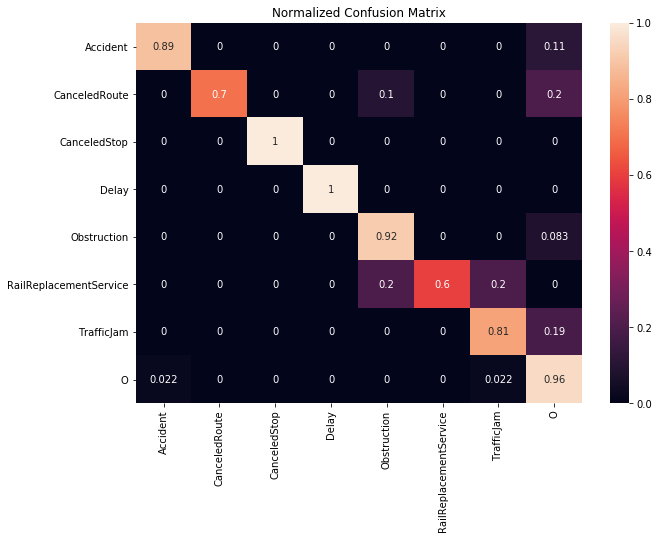

In [13]:
plot_confusion_matrix(trigger_y_true, trigger_y_pred, labels=SD4M_RELATION_TYPES)

### Argument role classification

In [14]:
print(sklearn.metrics.classification_report(arg_y_true, arg_y_pred, ROLE_LABELS[:-1]))

              precision    recall  f1-score   support

    location       0.80      0.48      0.60        84
       delay       0.00      0.00      0.00         8
   direction       0.83      0.77      0.80        31
   start_loc       0.80      0.82      0.81        39
     end_loc       0.88      0.74      0.80        38
  start_date       0.70      0.78      0.74         9
    end_date       1.00      1.00      1.00         2
       cause       1.00      0.73      0.85        15
  jam_length       0.93      1.00      0.96        13
       route       1.00      0.33      0.50         3

   micro avg       0.84      0.65      0.73       242
   macro avg       0.79      0.67      0.71       242
weighted avg       0.81      0.65      0.71       242



/Users/phuc/opt/miniconda3/envs/eventx/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


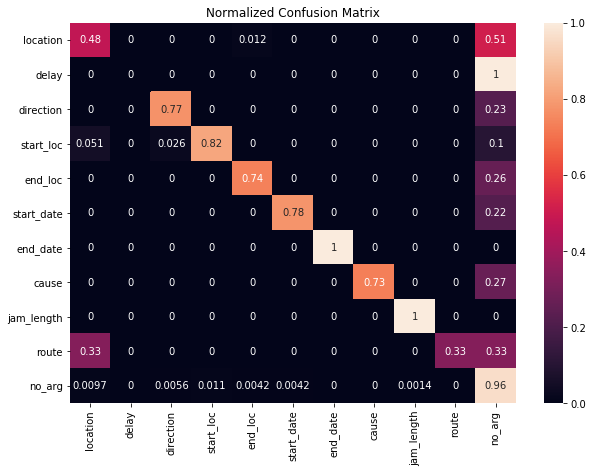

In [15]:
plot_confusion_matrix(arg_y_true, arg_y_pred, labels=ROLE_LABELS)

## Event extraction evaluation using correctness criteria defined by Ji, Heng and Grishman, Ralph 2008

Ji, Heng and Grishman, Ralph (2008). Refining event extraction through cross-document inference.
> - A trigger is correctly labeled if its event type and offsets match a reference trigger.
> - An argument is correctly identified if its event type and offsets match any of the reference argument mentions.
> - An argument is correctly identified and classified if its event type, offsets, and role match any of the reference argument mentions.

The main difference to the previous evaluation method lies in the correctness criteria for the arguments. Here we additionally consider the correctness of the event type for the argument.

Caution:
Using the following methods to retrieve the triggers and arguments from the gold data might result in duplicate gold triggers & arguments.
This is due to different events possibly sharing the same trigger.
The model is not able to distinguish such events and instead fuses them all together, which results in lower recall.
If we remove duplicates from the gold triggers and gold arguments, recall and consequently f1 should be higher.

In [16]:
REMOVE_DUPLICATES = True  # change to False if you want to keep duplicate triggers/ arguments from the gold data caused by events sharing the same trigger

In [17]:
gold_triggers = scorer.get_triggers(test_docs)
gold_arguments = scorer.get_arguments(test_docs)
pred_triggers = scorer.get_triggers(predicted_docs)
pred_arguments = scorer.get_arguments(predicted_docs)

In [18]:
if REMOVE_DUPLICATES:
    gold_triggers = list(set(gold_triggers))
    gold_arguments = list(set(gold_arguments))

In [19]:
trigger_id_metrics = scorer.get_trigger_identification_metrics(gold_triggers, pred_triggers, output_string=True)

--------------------------------------------------------------------------------
                               precision    recall  f1-score   support
--------------------------------------------------------------------------------
Trigger identification              0.96      0.88      0.92        57


In [20]:
trigger_class_metrics = scorer.get_trigger_classification_metrics(gold_triggers, pred_triggers, output_string=True)

--------------------------------------------------------------------------------
                               precision    recall  f1-score   support
--------------------------------------------------------------------------------
Trigger classification              0.90      0.82      0.86        57
Accident                            0.89      0.89      0.89         9
CanceledRoute                       1.00      0.70      0.82        10
CanceledStop                        1.00      1.00      1.00         3
Delay                               1.00      1.00      1.00         2
Obstruction                         0.85      0.92      0.88        12
RailReplacementService              1.00      0.60      0.75         5
TrafficJam                          0.87      0.81      0.84        16


In [21]:
argument_id_metrics = scorer.get_argument_identification_metrics(gold_arguments, pred_arguments, output_string=True)

--------------------------------------------------------------------------------
                               precision    recall  f1-score   support
--------------------------------------------------------------------------------
Argument identification             0.83      0.64      0.72       244


In [22]:
argument_class_metrics = scorer.get_argument_classification_metrics(gold_arguments, pred_arguments, output_string=True)

2020-07-18 00:30:58,313 - Precision and F-score are ill-defined and being set to 0.0 in # labels with no predicted samples
2020-07-18 00:30:58,313 - Precision and F-score are ill-defined and being set to 0.0 in # labels with no predicted samples


--------------------------------------------------------------------------------
                               precision    recall  f1-score   support
--------------------------------------------------------------------------------
Argument classification             0.80      0.62      0.70       244
location                            0.78      0.46      0.58        84
delay                               0.00      0.00      0.00         8
direction                           0.83      0.77      0.80        31
start_loc                           0.75      0.77      0.76        39
end_loc                             0.81      0.67      0.73        39
start_date                          0.50      0.56      0.53         9
end_date                            1.00      0.67      0.80         3
cause                               1.00      0.73      0.85        15
jam_length                          0.93      1.00      0.96        13
route                               1.00      0.33      0